In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os
import joblib
import pickle
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set dataset path
train_dir = r"/content/drive/MyDrive/Guvi Project/Dataset/images/data/train"
test_dir = r"/content/drive/MyDrive/Guvi Project/Dataset/images/data/test"
val_dir = r"/content/drive/MyDrive/Guvi Project/Dataset/images/data/val"

In [4]:
img_size = (224, 224)
batch_size = 32

In [5]:
# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only Rescale for Validation & Test Sets (No Augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Load Data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 6232 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


In [7]:
# Load the pre-trained models training accuracy and loss
histories = {}

# Load the trained models
trained_models = {}

# Create directory for saving models
model_save_dir = r"/content/drive/MyDrive/Guvi Project/model"
os.makedirs(model_save_dir, exist_ok=True)

# Create a directory to save training & valuation histories
history_save_dir = "/content/drive/MyDrive/Guvi Project/history"
os.makedirs(history_save_dir, exist_ok=True)

# CSV file to store accuracy & loss results
csv_file = os.path.join(model_save_dir, "model_performance.csv")

# List to store model performance details
model_results = []


In [8]:
best = {
    "best_model_name" : None,
    "best_model" : None,
    "best_accuracy" : 0.0,
    "best_loss" : 0.0
}

In [ ]:
# Save trained model as .pkl
def find_best_model(name,model):
  # For safety purpose saving all the models
  model_filename = os.path.join(model_save_dir, f"{name}.pkl")
  joblib.dump(model, model_filename)
  print(f"Saved {name} model to {model_filename}")

  # Evaluate on test data
  loss, acc = model.evaluate(test_data)

  # Append results to list
  model_results.append([name, acc, loss])

  print(f"\n{name} - Accuracy: {acc:.4f}, Loss: {loss:.4f}")

  # Update best model based on highest accuracy
  if acc > best["best_accuracy"]:
      best["best_accuracy"] = acc
      best["best_model"] = model
      best["best_model_name"] = name  # Save model name
      best["best_loss"] = loss

In [ ]:
# CNN Model from Scratch
def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(11, activation='softmax')
    ])
    return model

In [ ]:
cnn_model = build_cnn_model()
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train CNN model
history_cnn = cnn_model.fit(train_data, validation_data=val_data, epochs=20)
find_best_model("CNN_model",cnn_model)
trained_models["CNN_model"] = cnn_model

# Save history as .pkl
history_cnn_filename = os.path.join(history_save_dir, f"cnn_model_history.pkl")
joblib.dump(history_cnn.history, history_cnn_filename)  # Save training history dictionary
print(f"Saved training history for cnn_model to {history_cnn_filename}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 3262s 17s/step - accuracy: 0.2425 - loss: 2.3876 - val_accuracy: 0.5641 - val_loss: 1.2359
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 104s 534ms/step - accuracy: 0.5243 - loss: 1.2999 - val_accuracy: 0.7042 - val_loss: 0.8651
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 99s 507ms/step - accuracy: 0.6242 - loss: 1.0362 - val_accuracy: 0.7170 - val_loss: 0.7049
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 145s 524ms/step - accuracy: 0.6860 - loss: 0.8607 - val_accuracy: 0.7720 - val_loss: 0.6190
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 99s 507ms/step - accuracy: 0.7267 - loss: 0.7723 - val_accuracy: 0.7802 - val_loss: 0.6333
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 99s 508ms/step - accuracy: 0.7732 - loss: 0.6184 - val_accuracy: 0.7875 - val_loss: 0.5691
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 143s 516ms/step - accuracy: 0.8095 - loss: 0.5464 - val_accuracy: 0.9121 - val_loss: 0.3181
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 99s 510ms/step - accuracy: 0.8254 - loss

In [ ]:
# Function to build a fine-tuned pre-trained model
def build_pretrained_model(base_model):
    base_model.trainable = True  # Unfreeze model for fine-tuning
    for layer in base_model.layers[:100]:  # Freeze first 100 layers
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(11, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=out)
    return model

In [ ]:
# Load Pretrained Models
models = {
    "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "MobileNet": MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "InceptionV3": InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for name, base_model in models.items():
    model = build_pretrained_model(base_model)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"Training {name} model...")
    history = model.fit(train_data, validation_data=val_data, epochs=20)
    histories[name] = history
    trained_models[name] = model
    find_best_model(name,model)

    # Save history as .pkl
    history_filename = os.path.join(history_save_dir, f"{name}_history.pkl")
    joblib.dump(history.history, history_filename)  # Save training history dictionary
    print(f"Saved training history for {name} to {history_filename}")

Training MobileNet model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 3725s 19s/step - accuracy: 0.6710 - loss: 1.0802 - val_accuracy: 0.9799 - val_loss: 0.0776
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 495ms/step - accuracy: 0.9431 - loss: 0.1718 - val_accuracy: 0.9863 - val_loss: 0.0445
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 97s 497ms/step - accuracy: 0.9671 - loss: 0.1125 - val_accuracy: 0.9881 - val_loss: 0.0364
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 98s 501ms/step - accuracy: 0.9722 - loss: 0.0878 - val_accuracy: 0.9890 - val_loss: 0.0274
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 98s 501ms/step - accuracy: 0.9638 - loss: 0.0954 - val_accuracy: 0.9982 - val_loss: 0.0172
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 142s 501ms/step - accuracy: 0.9784 - loss: 0.0647 - val_accuracy: 0.9936 - val_loss: 0.0220
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 98s 501ms/step - accuracy: 0.9717 - loss: 0.0844 - val_accuracy: 0.9890 - val_loss: 0.0439
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 97s 498ms/step - accuracy: 0.9770 - loss: 

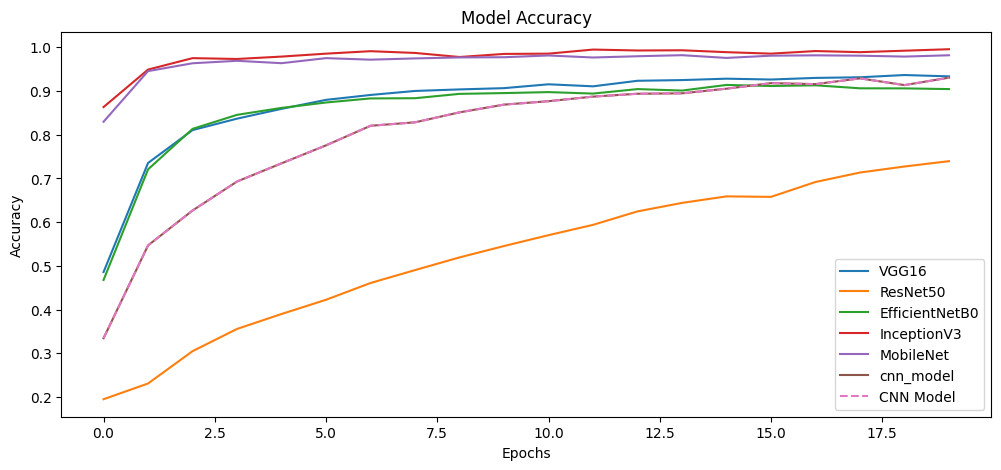

In [ ]:
# Compare Performance with Accuracy
plt.figure(figsize=(12, 5))
for name, history in histories.items():
    plt.plot(history.history['accuracy'], label=name)
plt.plot(history_cnn.history['accuracy'], label='CNN Model', linestyle='dashed')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

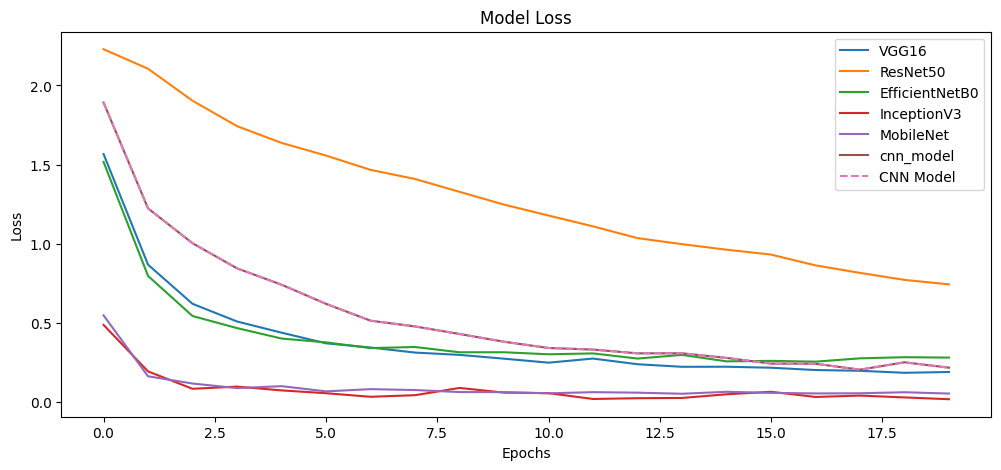

In [ ]:
# Compare Performance with Loss
plt.figure(figsize=(12, 5))
for name, history in histories.items():
    plt.plot(history.history['loss'], label=name)
plt.plot(history_cnn.history['loss'], label='CNN Model', linestyle='dashed')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Create directory for saving models
model_save_dir = r"/content/drive/MyDrive/Guvi Project/model"
os.makedirs(model_save_dir, exist_ok=True)

model_files = [f for f in os.listdir(model_save_dir)]

for file in model_files:
  model_file = os.path.join(model_save_dir,file)
  model = joblib.load(model_file)
  name = file.replace(".pkl", "")
  trained_models[name] = model


Calculating the Evaluation Metrics

In [ ]:
# Convert to DataFrame & Save as CSV
df = pd.DataFrame(model_results, columns=["Model Name", "Test Accuracy", "Test Loss"])
df.to_csv(csv_file, index=False)

print("All models saved and performance logged to CSV.")

# Save only the best model
if best["best_model"]:
    best_model_filename = os.path.join(model_save_dir, f"{best['best_model_name']}.pkl")
    joblib.dump(best['best_model'], best_model_filename)
    print(f"Best model {best['best_model_name']} saved with accuracy {best['best_accuracy']:.4f} to {best_model_filename}")

All models saved and performance logged to CSV.
Best model MobileNet saved with accuracy 0.9972 to /content/drive/MyDrive/Guvi Project/model/MobileNet.pkl


Evaluating CNN_model...
100/100 ━━━━━━━━━━━━━━━━━━━━ 98s 982ms/step

CNN_model - Accuracy: 0.9887, Loss: 0.0480, Precision: 0.9877, Recall: 0.9887, F1-score: 0.9875

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       520
           1       0.67      0.15      0.25        13
           2       1.00      1.00      1.00       298
           3       0.99      0.96      0.97       305
           4       0.99      1.00      1.00       286
           5       1.00      1.00      1.00       291
           6       0.99      1.00      0.99       273
           7       0.97      0.99      0.98       327
           8       1.00      1.00      1.00       289
           9       1.00      0.99      0.99       293
          10       0.99      0.99      0.99       292

    accuracy                           0.99      3187
   macro avg       0.96      0.92      0.92      3187
weighted avg       0.99      0.99      0.99      318

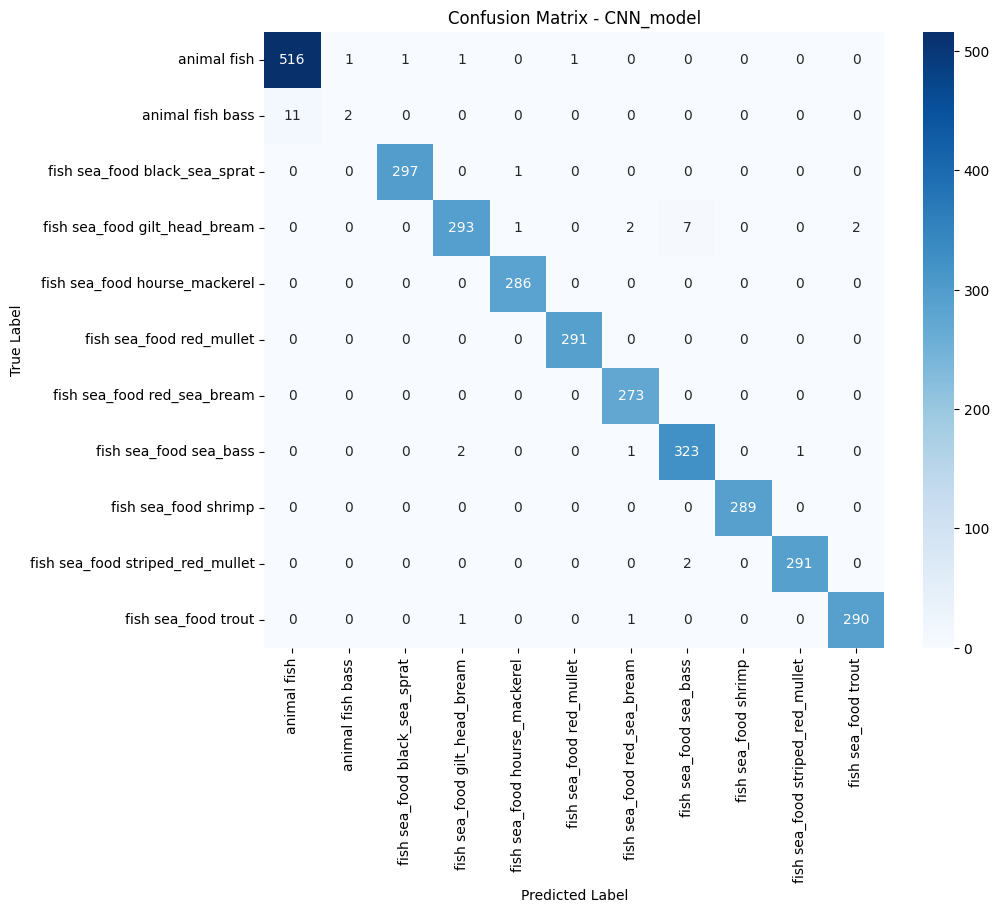

Evaluating VGG16...
100/100 ━━━━━━━━━━━━━━━━━━━━ 1295s 13s/step

VGG16 - Accuracy: 0.9752, Loss: 0.0857, Precision: 0.9758, Recall: 0.9752, F1-score: 0.9748

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       520
           1       1.00      0.38      0.56        13
           2       0.98      0.99      0.99       298
           3       0.98      1.00      0.99       305
           4       0.99      0.95      0.97       286
           5       0.96      0.93      0.95       291
           6       1.00      0.99      0.99       273
           7       1.00      0.97      0.99       327
           8       0.96      1.00      0.98       289
           9       0.89      0.94      0.92       293
          10       1.00      0.99      1.00       292

    accuracy                           0.98      3187
   macro avg       0.98      0.92      0.94      3187
weighted avg       0.98      0.98      0.97      3187



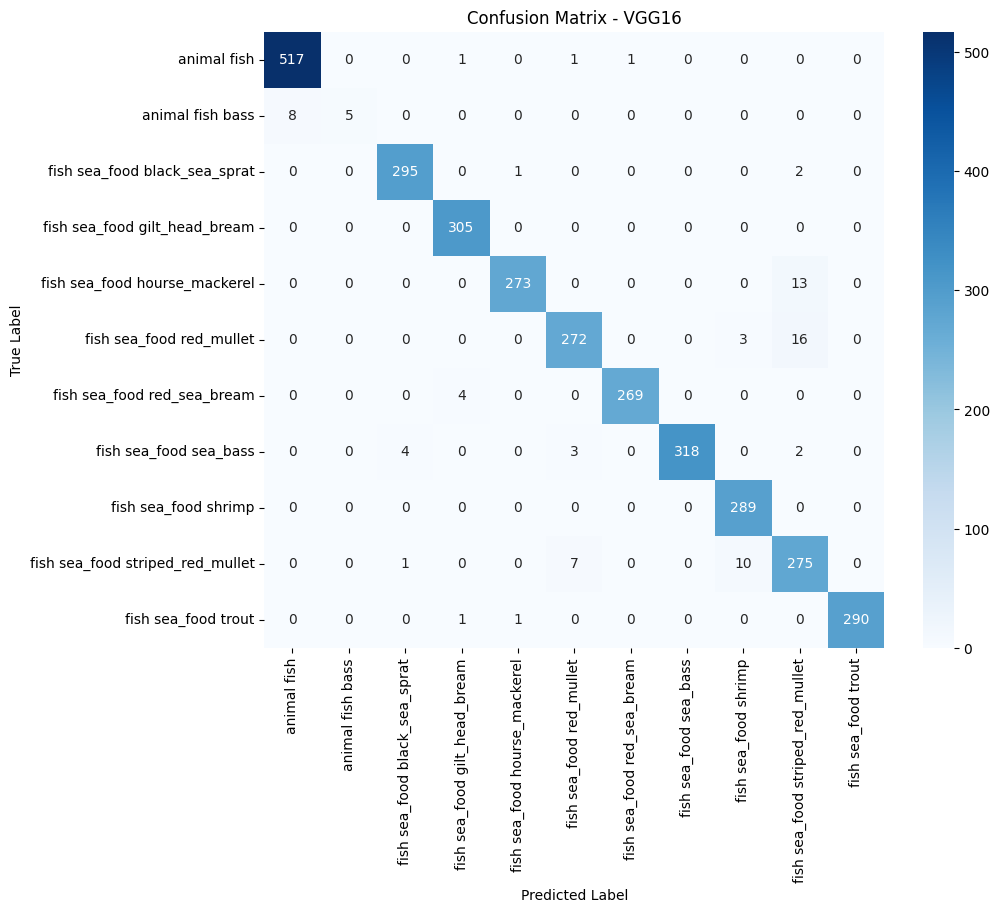

Evaluating ResNet50...
100/100 ━━━━━━━━━━━━━━━━━━━━ 377s 4s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


ResNet50 - Accuracy: 0.4619, Loss: 3.6636, Precision: 0.6403, Recall: 0.4619, F1-score: 0.4115

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93       520
           1       0.00      0.00      0.00        13
           2       0.92      0.74      0.82       298
           3       0.03      0.02      0.02       305
           4       0.42      0.35      0.38       286
           5       0.37      0.98      0.54       291
           6       0.22      0.90      0.35       273
           7       0.85      0.10      0.19       327
           8       0.95      0.28      0.43       289
           9       0.62      0.03      0.06       293
          10       0.86      0.02      0.04       292

    accuracy                           0.46      3187
   macro avg       0.56      0.40      0.34      3187
weighted avg       0.64      0.46      0.41      3187



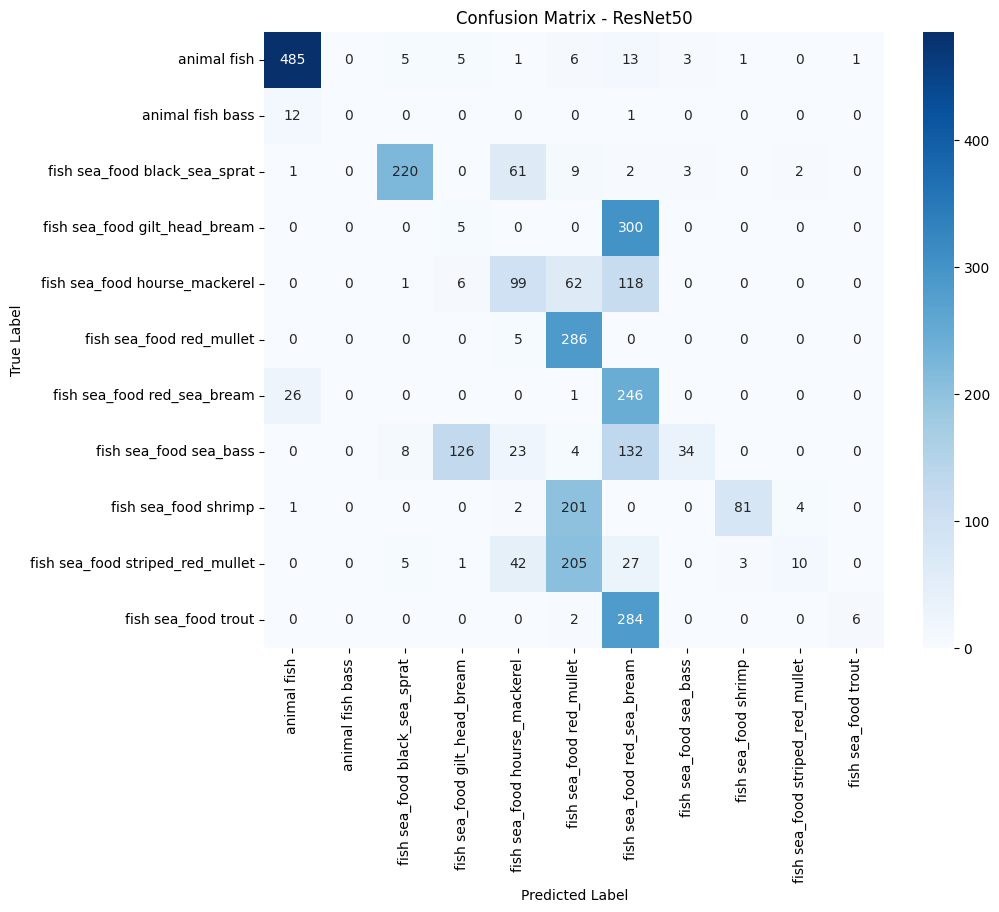

Evaluating EfficientNetB0...
100/100 ━━━━━━━━━━━━━━━━━━━━ 840s 8s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


EfficientNetB0 - Accuracy: 0.5466, Loss: 1.3707, Precision: 0.7712, Recall: 0.5466, F1-score: 0.5266

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.96      0.51       520
           1       0.00      0.00      0.00        13
           2       0.95      0.62      0.75       298
           3       1.00      0.24      0.39       305
           4       0.83      0.71      0.76       286
           5       0.33      0.61      0.43       291
           6       0.78      0.77      0.78       273
           7       0.96      0.17      0.29       327
           8       0.83      0.78      0.81       289
           9       1.00      0.13      0.23       293
          10       1.00      0.26      0.41       292

    accuracy                           0.55      3187
   macro avg       0.73      0.48      0.49      3187
weighted avg       0.77      0.55      0.53      3187



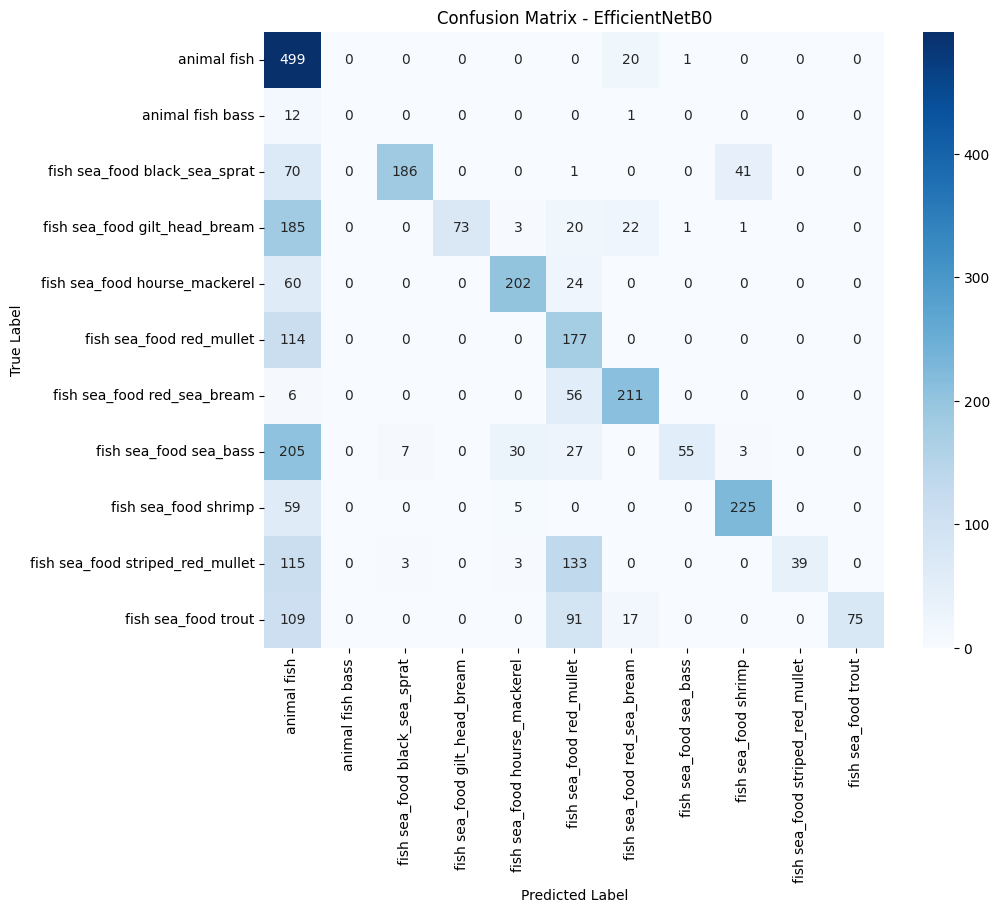

Evaluating InceptionV3...
100/100 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step

InceptionV3 - Accuracy: 0.9947, Loss: 0.0218, Precision: 0.9951, Recall: 0.9947, F1-score: 0.9948

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       520
           1       0.72      1.00      0.84        13
           2       1.00      1.00      1.00       298
           3       1.00      0.98      0.99       305
           4       1.00      1.00      1.00       286
           5       0.99      1.00      1.00       291
           6       0.99      1.00      0.99       273
           7       0.99      1.00      1.00       327
           8       0.99      1.00      1.00       289
           9       1.00      1.00      1.00       293
          10       1.00      1.00      1.00       292

    accuracy                           0.99      3187
   macro avg       0.97      1.00      0.98      3187
weighted avg       1.00      0.99      0.99      3

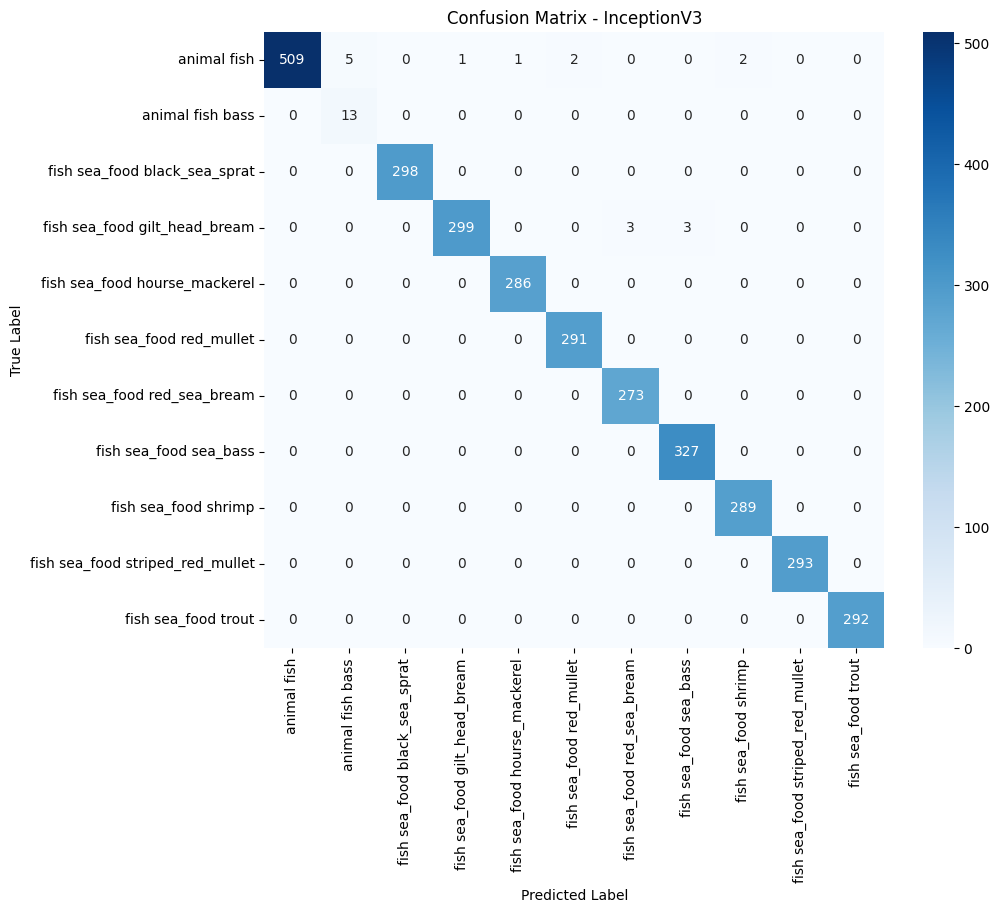

Evaluating MobileNet...
100/100 ━━━━━━━━━━━━━━━━━━━━ 546s 5s/step

MobileNet - Accuracy: 0.9972, Loss: 0.0098, Precision: 0.9972, Recall: 0.9972, F1-score: 0.9971

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       520
           1       1.00      0.69      0.82        13
           2       1.00      1.00      1.00       298
           3       1.00      0.99      1.00       305
           4       1.00      1.00      1.00       286
           5       1.00      0.99      0.99       291
           6       1.00      1.00      1.00       273
           7       1.00      1.00      1.00       327
           8       1.00      1.00      1.00       289
           9       0.99      1.00      0.99       293
          10       1.00      1.00      1.00       292

    accuracy                           1.00      3187
   macro avg       1.00      0.97      0.98      3187
weighted avg       1.00      1.00      1.00      3187


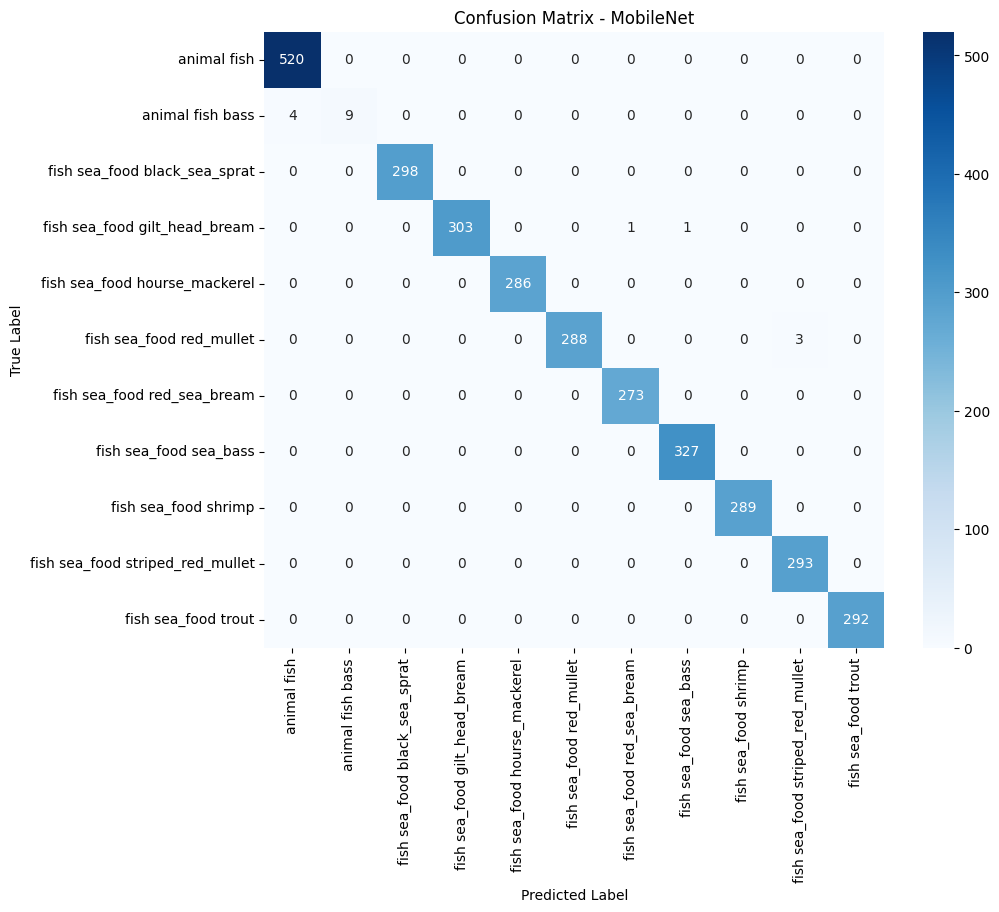

In [14]:
# Dictionary to store evaluation metrics
model_evaluation_results = {}

# Iterate through all models including CNN and Pretrained Models
for model_name, model in trained_models.items():  # Assuming trained_models contains all models
    print(f"Evaluating {model_name}...")

    # Get true labels and predictions
    y_true = test_data.classes  # Actual class labels
    y_pred_probs = model.predict(test_data)  # Model predictions (probabilities)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
    # Compute categorical crossentropy loss
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    loss = loss_fn(tf.one_hot(y_true, depth=len(test_data.class_indices)), y_pred_probs).numpy()

    # Compute Evaluation Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Store results
    model_evaluation_results[model_name] = {
        "Accuracy": accuracy,
        "Loss": loss,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

    # Print Results
    print(f"\n{model_name} - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

In [15]:
# Save evaluation results to a CSV file
df_results = pd.DataFrame.from_dict(model_evaluation_results, orient='index')
df_results.to_csv("/content/drive/MyDrive/Guvi Project/model_evaluation_results.csv")
print("Evaluation results saved to model_evaluation_results.csv")

Evaluation results saved to model_evaluation_results.csv


**The best model for Fish Image Classification**

Model       - **MobileNet**

Accuracy    - **0.9972**

Loss        - **0.0098**

Precision   - **0.9972**

Recall      - **0.9972**

F1-score    - **0.9971**